# Collaborative Filtering on Google Analytics Data


### Learning objectives
1. Prepare the user-item matrix and use it with WALS.
2. Train a `WALSMatrixFactorization` within TensorFlow locally and on AI Platform.
3. Visualize the embedding vectors with principal components analysis.


## Overview
This notebook demonstrates how to implement a WALS matrix refactorization approach to do collaborative filtering.

Each learning objective will correspond to a __#TODO__ in the notebook, where you will complete the notebook cell's code before running the cell. Refer to the [solution notebook](../solutions/wals.ipynb) for reference.


In [1]:
import os
PROJECT = "qwiklabs-gcp-04-27b219b6d4bb" # REPLACE WITH YOUR PROJECT ID
BUCKET = "qwiklabs-gcp-04-27b219b6d4bb" # REPLACE WITH YOUR BUCKET NAME
REGION = "us-central1" # REPLACE WITH YOUR BUCKET REGION e.g. us-central1

# Do not change these
os.environ["PROJECT"] = PROJECT
os.environ["BUCKET"] = BUCKET
os.environ["REGION"] = REGION
os.environ["TFVERSION"] = "1.15"

In [2]:
%%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

Updated property [core/project].
Updated property [compute/region].


In [3]:
import tensorflow as tf
print(tf.__version__)

1.15.5


## Create raw dataset
<p>
For collaborative filtering, you don't need to know anything about either the users or the content. Essentially, all you need to know is userId, itemId, and rating that the particular user gave the particular item.
<p>
In this case, you are working with newspaper articles. The company doesn't ask their users to rate the articles. However, you can use the time-spent on the page as a proxy for rating.
<p>
Normally, you would also add a time filter to this ("latest 7 days"), but your dataset is itself limited to a few days.

In [4]:
from google.cloud import bigquery
bq = bigquery.Client(project = PROJECT)

sql = """
WITH CTE_visitor_page_content AS (
    SELECT
        # Schema: https://support.google.com/analytics/answer/3437719?hl=en
        # For a completely unique visit-session ID, you combine combination of fullVisitorId and visitNumber:
        CONCAT(fullVisitorID,'-',CAST(visitNumber AS STRING)) AS visitorId,
        (SELECT MAX(IF(index=10, value, NULL)) FROM UNNEST(hits.customDimensions)) AS latestContentId,  
        (LEAD(hits.time, 1) OVER (PARTITION BY fullVisitorId ORDER BY hits.time ASC) - hits.time) AS session_duration 
    FROM
        `cloud-training-demos.GA360_test.ga_sessions_sample`,   
        UNNEST(hits) AS hits
    WHERE 
        # only include hits on pages
        hits.type = "PAGE"
GROUP BY   
        fullVisitorId,
        visitNumber,
        latestContentId,
        hits.time )
-- Aggregate web stats
SELECT   
    visitorId,
    latestContentId as contentId,
    SUM(session_duration) AS session_duration
FROM
    CTE_visitor_page_content
WHERE
    latestContentId IS NOT NULL 
GROUP BY
    visitorId, 
    latestContentId
HAVING 
    session_duration > 0
"""

df = bq.query(sql).to_dataframe()
df.head()

,visitorId,contentId,session_duration
0,1323217719614345513-1,299777082,127980
1,13578933974203543112-2,231169919,98872
2,1406452545090286958-1,299827911,2863
3,1469641478381610799-2,294663439,20309
4,1684632311211051431-280,298846345,47987


In [5]:
stats = df.describe()
stats

,session_duration
count,2.831240e+05
mean,1.252491e+05
std,2.318428e+05
min,1.000000e+00
25%,1.623400e+04
50%,5.662050e+04
75%,1.276405e+05
max,7.690598e+06


<AxesSubplot:ylabel='Frequency'>

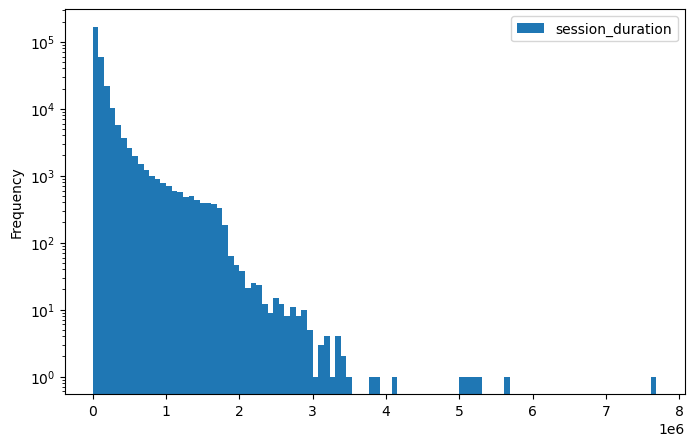

In [6]:
df[["session_duration"]].plot(kind="hist", logy=True, bins=100, figsize=[8,5])

<AxesSubplot:ylabel='Frequency'>

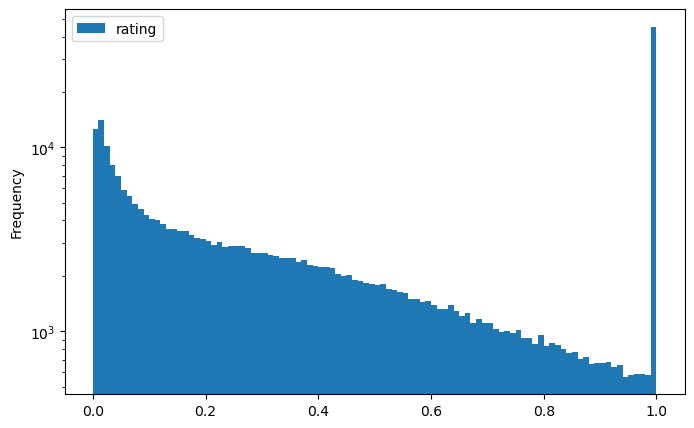

In [7]:
# The rating is the session_duration scaled to be in the range 0-1.  This will help with training.
median = stats.loc["50%", "session_duration"]
df["rating"] = 0.3 * df["session_duration"] / median
df.loc[df["rating"] > 1, "rating"] = 1
df[["rating"]].plot(kind="hist", logy=True, bins=100, figsize=[8,5])

In [8]:
del df["session_duration"]

In [9]:
%%bash
rm -rf data
mkdir data

In [10]:
# Write object to a comma-separated values (csv) file.
# TODO 1: Your code here
df.to_csv(path_or_buf = "data/collab_raw.csv", index = False, header = False)

In [11]:
!head data/collab_raw.csv

1323217719614345513-1,299777082,0.6780936233343047
13578933974203543112-2,231169919,0.5238667973613796
1406452545090286958-1,299827911,0.015169417437147323
1469641478381610799-2,294663439,0.1076059024558243
1684632311211051431-280,298846345,0.25425596736164463
1762944051909358582-224,869838,1.0
2074767091526628051-1,299934703,0.6283784141786102
2416856907227070734-585,298699683,0.7138951439849525
2821691900324136088-306,299915364,0.9402760484276896
2824919400739698829-413,299918857,0.03787320846689803


## Create dataset for WALS
<p>
The raw dataset (above) won't work for WALS:
<ol>
<li> The userId and itemId have to be 0,1,2 ... so you need to create a mapping from visitorId (in the raw data) to userId and contentId (in the raw data) to itemId.
<li> You will need to save the above mapping to a file because at prediction time, you'll need to know how to map the contentId in the table above to the itemId.
<li> You'll need two files: a "rows" dataset where all the items for a particular user are listed; and a "columns" dataset where all the users for a particular item are listed.
</ol>

<p>

### Mapping

In [12]:
import pandas as pd
import numpy as np
def create_mapping(values, filename):
    with open(filename, 'w') as ofp:
        value_to_id = {value:idx for idx, value in enumerate(values.unique())}
        for value, idx in value_to_id.items():
            ofp.write("{},{}\n".format(value, idx))
    return value_to_id

df = pd.read_csv(filepath_or_buffer = "data/collab_raw.csv",
                 header = None,
                 names = ["visitorId", "contentId", "rating"],
                dtype = {"visitorId": str, "contentId": str, "rating": np.float})
df.to_csv(path_or_buf = "data/collab_raw.csv", index = False, header = False)
user_mapping = create_mapping(df["visitorId"], "data/users.csv")
item_mapping = create_mapping(df["contentId"], "data/items.csv")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]


In [13]:
!head -3 data/*.csv

==> data/collab_raw.csv <==
1323217719614345513-1,299777082,0.6780936233343047
13578933974203543112-2,231169919,0.5238667973613796
1406452545090286958-1,299827911,0.0151694174371473

==> data/items.csv <==
299777082,0
231169919,1
299827911,2

==> data/users.csv <==
1323217719614345513-1,0
13578933974203543112-2,1
1406452545090286958-1,2


In [14]:
df["userId"] = df["visitorId"].map(user_mapping.get)
df["itemId"] = df["contentId"].map(item_mapping.get)

In [15]:
mapped_df = df[["userId", "itemId", "rating"]]
mapped_df.to_csv(path_or_buf = "data/collab_mapped.csv", index = False, header = False)
mapped_df.head()

,userId,itemId,rating
0,0,0,0.678094
1,1,1,0.523867
2,2,2,0.015169
3,3,3,0.107606
4,4,4,0.254256


### Creating rows and columns datasets

In [16]:
import pandas as pd
import numpy as np
mapped_df = pd.read_csv(filepath_or_buffer = "data/collab_mapped.csv", header = None, names = ["userId", "itemId", "rating"])
mapped_df.head()

,userId,itemId,rating
0,0,0,0.678094
1,1,1,0.523867
2,2,2,0.015169
3,3,3,0.107606
4,4,4,0.254256


In [17]:
NITEMS = np.max(mapped_df["itemId"]) + 1
NUSERS = np.max(mapped_df["userId"]) + 1
mapped_df["rating"] = np.round(mapped_df["rating"].values, 2)
print("{} items, {} users, {} interactions".format( NITEMS, NUSERS, len(mapped_df) ))

5596 items, 118858 users, 283124 interactions


In [18]:
grouped_by_items = mapped_df.groupby("itemId")
iter = 0
for item, grouped in grouped_by_items:
    print(item, grouped["userId"].values, grouped["rating"].values)
    iter = iter + 1
    if iter > 5:
        break

0 [    0    47   313   730   781   893  1301  1435  1652  2296  2586  2687
  3011  3267  3539  3610  3646  3668  3963  4243  4394  4588  4667  4721
  4979  4985  5178  5179  5202  5345  5814  5853  2938  6386  3528  6852
  6869  7107  7237  1542  7678  7923  7971  8451  6259  6292  9145   186
  9254  9740  9840  4269  9990  7339 10075 10148 10269 10459 10775 10961
  8438 11173 11290 11603  3294  3390 11895   283  9385 12113 12252 12280
   884  7406  1700  1969 13374 13568 14064 14290 14508 14617  3903 14962
  9841  7349 15561 15589  2266  2282 16890 17211  3965 17742 17954 12924
 18021 18163 18336  5443 16501 19036   319  6810 20095 20117 20118  2118
 18880 21331 19106 11672 19330 21801 12094 22210 22222 20492 23179 11065
 23424 23508  2949 11524 16813 23717  3298 24103  6902 24282 24391 24533
  4719 22791 25228 25323 10975 25634 11951  9352 17378 17449 26599  1369
  7481 26861 10296 26992 24988 20735  1955 16330  5568  8423 17140 28371
 28388 20416 28922 13130  1787 29217  5318 29693 

In [19]:
import tensorflow as tf
grouped_by_items = mapped_df.groupby("itemId")
with tf.python_io.TFRecordWriter("data/users_for_item") as ofp:
    for item, grouped in grouped_by_items:
        example = tf.train.Example(features = tf.train.Features(feature = {
            "key": tf.train.Feature(int64_list = tf.train.Int64List(value = [item])),
            "indices": tf.train.Feature(int64_list = tf.train.Int64List(value = grouped["userId"].values)),
            "values": tf.train.Feature(float_list = tf.train.FloatList(value = grouped["rating"].values))
        }))
        ofp.write(example.SerializeToString())

In [20]:
grouped_by_users = mapped_df.groupby("userId")
with tf.python_io.TFRecordWriter("data/items_for_user") as ofp:
    for user, grouped in grouped_by_users:
        example = tf.train.Example(features = tf.train.Features(feature = {
            "key": tf.train.Feature(int64_list = tf.train.Int64List(value = [user])),
            "indices": tf.train.Feature(int64_list = tf.train.Int64List(value = grouped["itemId"].values)),
            "values": tf.train.Feature(float_list = tf.train.FloatList(value = grouped["rating"].values))
        }))
        ofp.write(example.SerializeToString())

In [21]:
!ls -lrt data

total 36276
-rw-r--r-- 1 jupyter jupyter 14066967 Jul 19 21:19 collab_raw.csv
-rw-r--r-- 1 jupyter jupyter  3465266 Jul 19 21:19 users.csv
-rw-r--r-- 1 jupyter jupyter    81116 Jul 19 21:19 items.csv
-rw-r--r-- 1 jupyter jupyter  7635480 Jul 19 21:19 collab_mapped.csv
-rw-r--r-- 1 jupyter jupyter  2282888 Jul 19 21:19 users_for_item
-rw-r--r-- 1 jupyter jupyter  9598112 Jul 19 21:19 items_for_user


To summarize, you created the following data files from collab_raw.csv:
<ol>
<li> ```collab_mapped.csv``` is essentially the same data as in ```collab_raw.csv``` except that ```visitorId``` and ```contentId``` which are business-specific have been mapped to ```userId``` and ```itemId``` which are enumerated in 0,1,2,....  The mappings themselves are stored in ```items.csv``` and ```users.csv``` so that they can be used during inference.
<li> ```users_for_item``` contains all the users/ratings for each item in TFExample format
<li> ```items_for_user``` contains all the items/ratings for each user in TFExample format
</ol>

## Train with WALS

Once you have the dataset, do matrix factorization with WALS using the [WALSMatrixFactorization](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/contrib/factorization/WALSMatrixFactorization) in the contrib directory.
This is an estimator model, so it should be relatively familiar.
<p>
As usual, you write an input_fn to provide the data to the model, and then create the Estimator to do train_and_evaluate.
Because it is in contrib and hasn't moved over to tf.estimator yet, you use tf.contrib.learn.Experiment to handle the training loop.<p>
Make sure to replace <strong># TODO</strong> in below code.

In [37]:
import os
import tensorflow as tf
from tensorflow.python.lib.io import file_io
from tensorflow.contrib.factorization import WALSMatrixFactorization
  
def read_dataset(mode, args):
# TODO 2: Decode the example
    def decode_example(protos, vocab_size):
        features = {
            "key": tf.FixedLenFeature(shape = [1], dtype = tf.int64),
            "indices": tf.VarLenFeature(dtype = tf.int64),
            "values": tf.VarLenFeature(dtype = tf.float32)}
        parsed_features = tf.parse_single_example(serialized = protos, features = features)
        values = tf.sparse_merge(sp_ids = parsed_features["indices"], sp_values = parsed_features["values"], vocab_size = vocab_size)
        # Save key to remap after batching
        # This is a temporary workaround to assign correct row numbers in each batch.
        # You can ignore details of this part and remap_keys().
        key = parsed_features["key"]
        decoded_sparse_tensor = tf.SparseTensor(indices = tf.concat(values = [values.indices, [key]], axis = 0), 
                                                values = tf.concat(values = [values.values, [0.0]], axis = 0), 
                                                dense_shape = values.dense_shape)
        return decoded_sparse_tensor
  
  
    def remap_keys(sparse_tensor):
        # Current indices of your SparseTensor that you need to fix
        bad_indices = sparse_tensor.indices # shape = (current_batch_size * (number_of_items/users[i] + 1), 2)
        # Current values of your SparseTensor that you need to fix
        bad_values = sparse_tensor.values # shape = (current_batch_size * (number_of_items/users[i] + 1),)

        # Since batch is ordered, the last value for a batch index is the user
        # Find where the batch index chages to extract the user rows
        # 1 where user, else 0
        user_mask = tf.concat(values = [bad_indices[1:,0] - bad_indices[:-1,0], tf.constant(value = [1], dtype = tf.int64)], axis = 0) # shape = (current_batch_size * (number_of_items/users[i] + 1), 2)

        # Mask out the user rows from the values
        good_values = tf.boolean_mask(tensor = bad_values, mask = tf.equal(x = user_mask, y = 0)) # shape = (current_batch_size * number_of_items/users[i],)
        item_indices = tf.boolean_mask(tensor = bad_indices, mask = tf.equal(x = user_mask, y = 0)) # shape = (current_batch_size * number_of_items/users[i],)
        user_indices = tf.boolean_mask(tensor = bad_indices, mask = tf.equal(x = user_mask, y = 1))[:, 1] # shape = (current_batch_size,)

        good_user_indices = tf.gather(params = user_indices, indices = item_indices[:,0]) # shape = (current_batch_size * number_of_items/users[i],)

        # User and item indices are rank 1, need to make rank 1 to concat
        good_user_indices_expanded = tf.expand_dims(input = good_user_indices, axis = -1) # shape = (current_batch_size * number_of_items/users[i], 1)
        good_item_indices_expanded = tf.expand_dims(input = item_indices[:, 1], axis = -1) # shape = (current_batch_size * number_of_items/users[i], 1)
        good_indices = tf.concat(values = [good_user_indices_expanded, good_item_indices_expanded], axis = 1) # shape = (current_batch_size * number_of_items/users[i], 2)

        remapped_sparse_tensor = tf.SparseTensor(indices = good_indices, values = good_values, dense_shape = sparse_tensor.dense_shape)
        return remapped_sparse_tensor

    
    def parse_tfrecords(filename, vocab_size):
        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = None # indefinitely
        else:
            num_epochs = 1 # end-of-input after this

        files = tf.gfile.Glob(filename = os.path.join(args["input_path"], filename))

        # Create dataset from file list
        dataset = tf.data.TFRecordDataset(files)
        dataset = dataset.map(map_func = lambda x: decode_example(x, vocab_size))
        dataset = dataset.repeat(count = num_epochs)
        dataset = dataset.batch(batch_size = args["batch_size"])
        dataset = dataset.map(map_func = lambda x: remap_keys(x))
        return dataset.make_one_shot_iterator().get_next()
  
    def _input_fn():
        features = {
            WALSMatrixFactorization.INPUT_ROWS: parse_tfrecords("items_for_user", args["nitems"]),
            WALSMatrixFactorization.INPUT_COLS: parse_tfrecords("users_for_item", args["nusers"]),
            WALSMatrixFactorization.PROJECT_ROW: tf.constant(True)
        }
        return features, None

    return _input_fn

This code is helpful in developing the input function. You don't need it in production.

In [38]:
def try_out():
    with tf.Session() as sess:
        fn = read_dataset(
            mode = tf.estimator.ModeKeys.EVAL, 
            args = {"input_path": "data", "batch_size": 4, "nitems": NITEMS, "nusers": NUSERS})
        feats, _ = fn()
        
        print(feats["input_rows"].eval())
        print(feats["input_rows"].eval())

try_out()

SparseTensorValue(indices=array([[   0,    0],
       [   0,  126],
       [   0,  463],
       [   0, 1410],
       [   0, 5551],
       [   0, 5571],
       [   1,    1],
       [   1,   82],
       [   1,   87],
       [   1,  487],
       [   1,  561],
       [   1,  692],
       [   1, 1546],
       [   1, 1907],
       [   1, 2044],
       [   1, 2591],
       [   1, 2771],
       [   1, 3552],
       [   1, 3553],
       [   1, 4292],
       [   1, 4567],
       [   1, 5295],
       [   1, 5408],
       [   1, 5550],
       [   1, 5551],
       [   1, 5555],
       [   1, 5559],
       [   1, 5571],
       [   1, 5576],
       [   1, 5585],
       [   2,    2],
       [   2,   70],
       [   2,  183],
       [   2, 5552],
       [   2, 5553],
       [   2, 5556],
       [   2, 5557],
       [   2, 5558],
       [   2, 5559],
       [   3,    3],
       [   3,   82],
       [   3,   87],
       [   3, 5551],
       [   3, 5571]]), values=array([0.68, 0.85, 1.  , 0.3 , 0.53, 0.53

OMP: Info #250: KMP_AFFINITY: pid 2256 tid 3346 thread 3 bound to OS proc set 0


In [39]:
def find_top_k(user, item_factors, k):
    all_items = tf.matmul(a = tf.expand_dims(input = user, axis = 0), b = tf.transpose(a = item_factors))
    topk = tf.nn.top_k(input = all_items, k = k)
    return tf.cast(x = topk.indices, dtype = tf.int64)
    
def batch_predict(args):
    import numpy as np
    with tf.Session() as sess:
        estimator = tf.contrib.factorization.WALSMatrixFactorization(
            num_rows = args["nusers"], 
            num_cols = args["nitems"],
            embedding_dimension = args["n_embeds"],
            model_dir = args["output_dir"])
        
        # This is how you would get the row factors for out-of-vocab user data
        # row_factors = list(estimator.get_projections(input_fn=read_dataset(tf.estimator.ModeKeys.EVAL, args)))
        # user_factors = tf.convert_to_tensor(np.array(row_factors))

        # But for in-vocab data, the row factors are already in the checkpoint
        user_factors = tf.convert_to_tensor(value = estimator.get_row_factors()[0]) # (nusers, nembeds)
        # In either case, you have to assume catalog doesn"t change, so col_factors are read in
        item_factors = tf.convert_to_tensor(value = estimator.get_col_factors()[0])# (nitems, nembeds)

        # For each user, find the top K items
        topk = tf.squeeze(input = tf.map_fn(fn = lambda user: find_top_k(user, item_factors, args["topk"]), elems = user_factors, dtype = tf.int64))
        with file_io.FileIO(os.path.join(args["output_dir"], "batch_pred.txt"), mode = 'w') as f:
            for best_items_for_user in topk.eval():
                f.write(",".join(str(x) for x in best_items_for_user) + '\n')

def train_and_evaluate(args):
    train_steps = int(0.5 + (1.0 * args["num_epochs"] * args["nusers"]) / args["batch_size"])
    steps_in_epoch = int(0.5 + args["nusers"] / args["batch_size"])
    print("Will train for {} steps, evaluating once every {} steps".format(train_steps, steps_in_epoch))
    def experiment_fn(output_dir):
        return tf.contrib.learn.Experiment(
            tf.contrib.factorization.WALSMatrixFactorization(
                num_rows = args["nusers"], 
                num_cols = args["nitems"],
                embedding_dimension = args["n_embeds"],
                model_dir = args["output_dir"]),
            train_input_fn = read_dataset(tf.estimator.ModeKeys.TRAIN, args),
            eval_input_fn = read_dataset(tf.estimator.ModeKeys.EVAL, args),
            train_steps = train_steps,
            eval_steps = 1,
            min_eval_frequency = steps_in_epoch
        )

    from tensorflow.contrib.learn.python.learn import learn_runner
    learn_runner.run(experiment_fn = experiment_fn, output_dir = args["output_dir"])
    
    batch_predict(args)

In [40]:
import shutil
shutil.rmtree(path = "wals_trained", ignore_errors=True)
train_and_evaluate({
    "output_dir": "wals_trained",
    "input_path": "data/",
    "num_epochs": 0.05,
    "nitems": NITEMS,
    "nusers": NUSERS,

    "batch_size": 512,
    "n_embeds": 10,
    "topk": 3
  })

Will train for 12 steps, evaluating once every 232 steps
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f3e92f4a250>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_eval_distribute': None, '_experimental_max_worker_delay_secs': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_protocol': None, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'wals_trained', '_session_creation_timeout_secs': 7200}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tenso

OMP: Info #250: KMP_AFFINITY: pid 2256 tid 3419 thread 3 bound to OS proc set 0


INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Next fit step starting.
INFO:tensorflow:Saving checkpoints for 12 into wals_trained/model.ckpt.
INFO:tensorflow:Loss for final step: 167945.84.
INFO:tensorflow:Starting evaluation at 2024-07-19T21:32:07Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from wals_trained/model.ckpt-12
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]


OMP: Info #250: KMP_AFFINITY: pid 2256 tid 3459 thread 3 bound to OS proc set 0


INFO:tensorflow:Finished evaluation at 2024-07-19-21:32:08
INFO:tensorflow:Saving dict for global step 12: global_step = 12, loss = 188850.23
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f3e92e472d0>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_eval_distribute': None, '_experimental_max_worker_delay_secs': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_protocol': None, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'wals_trained', '_session_creation_timeout_secs': 7200}


In [41]:
!ls wals_trained

batch_pred.txt			  model.ckpt-0.meta
checkpoint			  model.ckpt-12.data-00000-of-00001
graph.pbtxt			  model.ckpt-12.index
model.ckpt-0.data-00000-of-00001  model.ckpt-12.meta
model.ckpt-0.index


In [42]:
!head wals_trained/batch_pred.txt

3973,3604,484
2894,2887,4355
3259,3448,5441
1036,3067,2665
1719,3670,4138
2927,1116,81
4473,3604,2064
633,3491,1644
1068,3458,1934
2587,4724,2426


## Run as a Python module

Let's run it as Python module for just a few steps.

In [43]:
os.environ["NITEMS"] = str(NITEMS)
os.environ["NUSERS"] = str(NUSERS)

In [44]:
%%bash
rm -rf wals.tar.gz wals_trained
gcloud ai-platform local train \
    --module-name=walsmodel.task \
    --package-path=${PWD}/walsmodel \
    -- \
    --output_dir=${PWD}/wals_trained \
    --input_path=${PWD}/data \
    --num_epochs=0.01 --nitems=${NITEMS} --nusers=${NUSERS} \
    --job-dir=./tmp

Will train for 2 steps, evaluating once every 232 steps




Instructions for updating:
Use tf.estimator.train_and_evaluate.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f10ccc0a350>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'cloud', '_is_chief': True, '_evaluation_master': '', '_train

CalledProcessError: Command 'b'rm -rf wals.tar.gz wals_trained\ngcloud ai-platform local train \\\n    --module-name=walsmodel.task \\\n    --package-path=${PWD}/walsmodel \\\n    -- \\\n    --output_dir=${PWD}/wals_trained \\\n    --input_path=${PWD}/data \\\n    --num_epochs=0.01 --nitems=${NITEMS} --nusers=${NUSERS} \\\n    --job-dir=./tmp\n'' returned non-zero exit status 1.

## Get row and column factors

Once you have a trained WALS model, you can get row and column factors (user and item embeddings) from the checkpoint file. You'll look at how to use these in the section on building a recommendation system using deep neural networks.

In [45]:
def get_factors(args):
    with tf.Session() as sess:
        estimator = tf.contrib.factorization.WALSMatrixFactorization(
            num_rows = args["nusers"], 
            num_cols = args["nitems"],
            embedding_dimension = args["n_embeds"],
            model_dir = args["output_dir"])
        
        row_factors = estimator.get_row_factors()[0]
        col_factors = estimator.get_col_factors()[0]
    return row_factors, col_factors

In [46]:
%%bash
echo $PWD/wals_trained

/home/jupyter/training-data-analyst/courses/machine_learning/deepdive2/recommendation_systems/labs/wals_trained


In [51]:
args = {
    "output_dir": "/home/jupyter/training-data-analyst/courses/machine_learning/deepdive2/recommendation_systems/labs/wals_trained", # ENTER THE OUTPUT FROM THE PREVIOUS CELL HERE
    "nitems": NITEMS,
    "nusers": NUSERS,
    "n_embeds": 10
  }

user_embeddings, item_embeddings = get_factors(args)
print(user_embeddings[:3])
print(item_embeddings[:3])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f3e92b22f90>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_eval_distribute': None, '_experimental_max_worker_delay_secs': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_protocol': None, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/home/jupyter/training-data-analyst/courses/machine_learning/deepdive2/recommendation_systems/labs/wals_trained', '_session_creation_timeout_secs': 7200}
[[ 0.002878   -0.00036657 -0.00074246  0.00484205

You can visualize the embedding vectors using dimensional reduction techniques such as PCA.

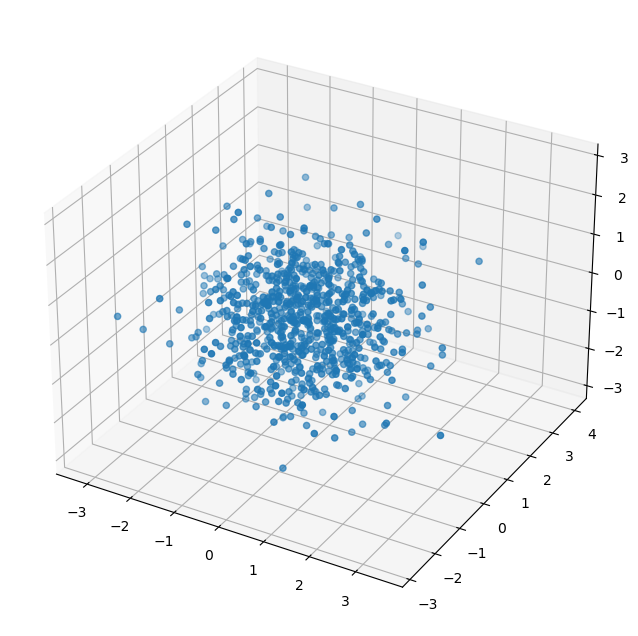

In [52]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

pca = PCA(n_components = 3)
pca.fit(user_embeddings)
# TODO 3: Apply the mapping (transform) to user embeddings
user_embeddings_pca = pca.transform(user_embeddings)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection = "3d")
xs, ys, zs = user_embeddings_pca[::150].T
ax.scatter(xs, ys, zs)

## OPTIONAL: Run on Cloud

In [53]:
%%bash
gsutil -m cp data/* gs://${BUCKET}/wals/data

Copying file://data/collab_mapped.csv [Content-Type=text/csv]...
Copying file://data/collab_raw.csv [Content-Type=text/csv]...
Copying file://data/items.csv [Content-Type=text/csv]...                        
Copying file://data/items_for_user [Content-Type=application/octet-stream]...   
Copying file://data/users.csv [Content-Type=text/csv]...                        
Copying file://data/users_for_item [Content-Type=application/octet-stream]...   
- [6/6 files][ 35.4 MiB/ 35.4 MiB] 100% Done                                    
Operation completed over 6 objects/35.4 MiB.                                     


In [54]:
%%bash
OUTDIR=gs://${BUCKET}/wals/model_trained
JOBNAME=wals_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ai-platform jobs submit training $JOBNAME \
    --region=$REGION \
    --module-name=walsmodel.task \
    --package-path=${PWD}/walsmodel \
    --job-dir=$OUTDIR \
    --staging-bucket=gs://$BUCKET \
    --scale-tier=BASIC_GPU \
    --runtime-version=$TFVERSION \
    -- \
    --output_dir=$OUTDIR \
    --input_path=gs://${BUCKET}/wals/data \
    --num_epochs=10 --nitems=${NITEMS} --nusers=${NUSERS} 

gs://qwiklabs-gcp-04-27b219b6d4bb/wals/model_trained us-central1 wals_240719_213520


CommandException: 1 files/objects could not be removed.
ERROR: (gcloud.ai-platform.jobs.submit.training) HttpError accessing <https://ml.googleapis.com/v1/projects/qwiklabs-gcp-04-27b219b6d4bb/jobs?alt=json>: response: <{'vary': 'Origin, X-Origin, Referer', 'content-type': 'application/json; charset=UTF-8', 'content-encoding': 'gzip', 'date': 'Fri, 19 Jul 2024 21:35:56 GMT', 'server': 'ESF', 'cache-control': 'private', 'x-xss-protection': '0', 'x-frame-options': 'SAMEORIGIN', 'x-content-type-options': 'nosniff', 'transfer-encoding': 'chunked', 'status': 429}>, content <{
  "error": {
    "code": 429,
    "message": "Quota failure for project qwiklabs-gcp-04-27b219b6d4bb. The request for 1 K80 accelerators exceeds the allowed maximum of 0 A100, 0 K80, 0 P100, 0 P4, 0 T4, 0 TPU_V2, 0 TPU_V2_POD, 0 TPU_V3, 0 TPU_V3_POD, 0 V100 accelerators. To read more about Cloud ML Engine quota, see https://cloud.google.com/ml-engine/quotas.",
    "status": "RESOURCE_EXHAUSTED",
    "details": [
      

CalledProcessError: Command 'b'OUTDIR=gs://${BUCKET}/wals/model_trained\nJOBNAME=wals_$(date -u +%y%m%d_%H%M%S)\necho $OUTDIR $REGION $JOBNAME\ngsutil -m rm -rf $OUTDIR\ngcloud ai-platform jobs submit training $JOBNAME \\\n    --region=$REGION \\\n    --module-name=walsmodel.task \\\n    --package-path=${PWD}/walsmodel \\\n    --job-dir=$OUTDIR \\\n    --staging-bucket=gs://$BUCKET \\\n    --scale-tier=BASIC_GPU \\\n    --runtime-version=$TFVERSION \\\n    -- \\\n    --output_dir=$OUTDIR \\\n    --input_path=gs://${BUCKET}/wals/data \\\n    --num_epochs=10 --nitems=${NITEMS} --nusers=${NUSERS} \n'' returned non-zero exit status 1.

This will take <b>10 minutes</b> to complete. Rerun the above command until the jobs gets submitted.

<pre>
# Copyright 2022 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
</pre>